# AE on CIFAR10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import tensorboard
from datetime import datetime

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data
- import
- normalize

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, _), (X_test, labels_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
labels_name = {0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

In [3]:
X_train.shape

(50000, 32, 32, 3)

## build AE

In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import regularizers

encoder

In [79]:
input_img = Input(shape=(32,32,3))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(128, (3, 3), activation='relu', 
                                padding='same')(input_img)
#encoded = Conv2D(64, (3, 3), activation='relu', 
#                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', 
                                padding='same')(encoded)
#encoded = Conv2D(32, (3, 3), activation='relu', 
#                                padding='same')(encoded)                                
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)

input_encoded_before_flatten = kb.int_shape(encoded)
encoded = Flatten()(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=kb.int_shape(encoded)[1:])
encoder.summary()


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_20 (Flatten)         (None, 4096)              0  

decoder

In [81]:
# model: decoder
decoded = Reshape(input_encoded_before_flatten[1:])(input_encoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 4096)]            0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d_22 (UpSampling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_23 (UpSampling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 32, 3)         173

autoencoder

### Metrics


In [117]:
from keras import backend as K
bce = tf.keras.losses.BinaryCrossentropy();

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def entropy(y_true, y_pred):
    return bce(y_true,y_true)

In [118]:
# model: autoencoder
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)
bce = tf.keras.losses.BinaryCrossentropy();
mse = tf.keras.losses.MeanSquaredError();

autoencoder.compile(optimizer=optimizer, loss=bce, metrics=['acc',f1_m,precision_m, recall_m, entropy])

autoencoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_39 (Functional)        (None, 4096)              114304    
_________________________________________________________________
model_41 (Functional)        (None, 32, 32, 3)         75587     
Total params: 189,891
Trainable params: 189,891
Non-trainable params: 0
_________________________________________________________________


## train AE

In [119]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0005)
ckpt_filepath = 'model/cifar10_ae/checkpoints/cifar10_ae-ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=128,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping,
                    checkpoint,
                    tensorboard_callback], # stop the training when no improvements are made
                verbose=1)

Epoch 1/25
391/391 [==============================] - 13s 31ms/step - loss: 0.5872 - acc: 0.6929 - f1_m: 0.4012 - precision_m: 0.4133 - recall_m: 0.4025 - entropy: 0.5464 - val_loss: 0.5549 - val_acc: 0.8164 - val_f1_m: 0.4563 - val_precision_m: 0.4507 - val_recall_m: 0.4620 - val_entropy: 0.5473
Epoch 2/25
391/391 [==============================] - 11s 27ms/step - loss: 0.5536 - acc: 0.8060 - f1_m: 0.4482 - precision_m: 0.4494 - recall_m: 0.4474 - entropy: 0.5463 - val_loss: 0.5537 - val_acc: 0.8147 - val_f1_m: 0.4546 - val_precision_m: 0.4485 - val_recall_m: 0.4609 - val_entropy: 0.5473
Epoch 3/25
391/391 [==============================] - 12s 30ms/step - loss: 0.5523 - acc: 0.8170 - f1_m: 0.4507 - precision_m: 0.4517 - recall_m: 0.4499 - entropy: 0.5461 - val_loss: 0.5531 - val_acc: 0.8365 - val_f1_m: 0.4507 - val_precision_m: 0.4490 - val_recall_m: 0.4525 - val_entropy: 0.5473
Epoch 4/25
391/391 [==============================] - 12s 31ms/step - loss: 0.5522 - acc: 0.8210 - f1_m: 0

## Plot loss


In [106]:
import skimage.measure    
entropy = skimage.measure.shannon_entropy(X_train)

In [107]:
print(entropy)

7.91188699993475


In [56]:
import matplotlib.pyplot as plt

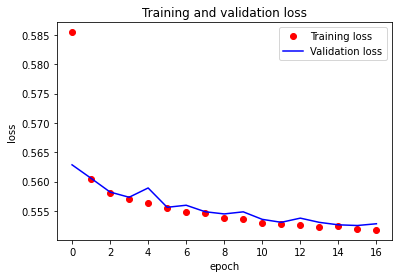

In [84]:
# summarize history for loss
plt.plot(history.history['loss'],'o',color='red')
plt.plot(history.history['val_loss'],color='blue')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

## save/load model

In [85]:
# save model
save_filepath = 'model/cifar10_ae/last'
autoencoder.save(
    filepath=save_filepath,
    overwrite=True,
    include_optimizer=True,
)


INFO:tensorflow:Assets written to: model/cifar10_ae/last\assets


## predict images

In [94]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [37]:
import matplotlib.pyplot as plt

## categorize by labels/categories

done now

In [95]:
decoded_imgs_classified=np.zeros((10,1000,32,32,3))
original_imgs_classified=np.zeros((10,1000,32,32,3))
for i in range(10): # it should be better this way if each category has the same number of items
    decoded_imgs_classified[i,:,:,:,:] = decoded_imgs[labels_test.reshape(-1,)==i].reshape(-1,32,32,3)
    original_imgs_classified[i,:,:,:,:] = X_test[labels_test.reshape(-1,)==i].reshape(-1,32,32,3)

### 10 classes

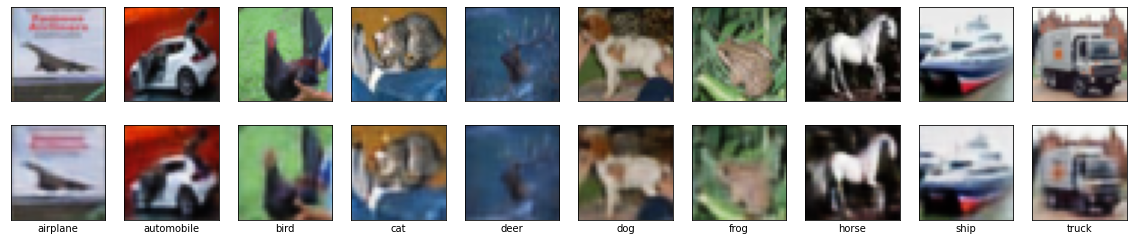

In [96]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs_classified[i,0])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_classified[i,0])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(labels_name[i])
plt.savefig('images/cifar10_ae/cifar10_reconstructed_all.png', dpi=120)
plt.show()

### 1 class

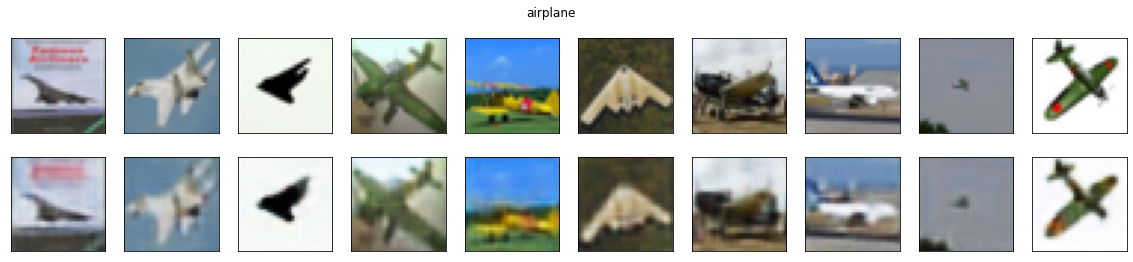

In [40]:
n = 10  # how many images we will display
fig = plt.figure(figsize=(20, 4))
selected_class = 0 # the class to be shown
for i in range(n):
    # display original
    ax = fig.add_subplot(2, n, i + 1)
    plt.imshow(original_imgs_classified[selected_class,i])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

    # display reconstruction
    ax = fig.add_subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_classified[selected_class,i])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(labels_name[selected_class])
plt.savefig('images/cifar10_ae/cifar10_reconstructed_'+str(selected_class)+'.png', dpi=120)
plt.show()

### loss for each class

In [111]:
bce = tf.keras.losses.BinaryCrossentropy();
mse = tf.keras.losses.MeanSquaredError();
loss_test = np.zeros(10)
input_entropy = np.zeros(10)
for i in range(10):
    loss_test[i] = bce(original_imgs_classified[i].reshape(-1,32*32*3),
        decoded_imgs_classified[i].reshape(-1,32*32*3)).numpy()
    input_entropy[i] = bce(original_imgs_classified[i].reshape(-1,32*32*3),
        original_imgs_classified[i].reshape(-1,32*32*3)).numpy()

[0.53640234 0.51833445 0.56800413 0.53940421 0.58386999 0.54728693
 0.55859172 0.54837763 0.55265409 0.52142268]


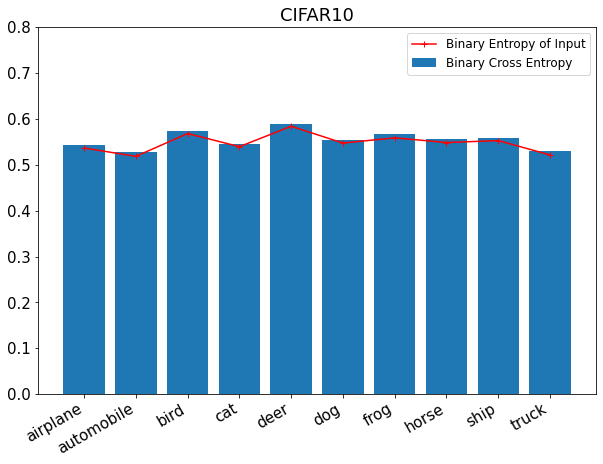

In [88]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)

bce_bar = ax.bar(range(10),loss_test)
e_line, = ax.plot(range(10),input_entropy, 'r+-')
ax.set_xticks(range(10))
ax.set_xticklabels(labels_name.values())

#ax.set_ylabel(ylabel='Binary Cross Entropy', fontsize=15)
ax.set_ylim((0,.8))

bce_bar.set_label('Binary Cross Entropy')
e_line.set_label('Binary Entropy of Input')
ax.legend(loc='upper right',
    fontsize='large')

ax.tick_params(labelsize=15)
ax.set_title('CIFAR10', fontsize=18)

fig.autofmt_xdate()

plt.savefig('images/cifar10_ae/cifar10_ae_bce.png',dpi=120)
plt.show()

### RMSE compared with STD of original image

In [44]:
mse = tf.keras.losses.MeanSquaredError();
rmse_test = np.zeros(10)
var_test = np.zeros(10)
for i in range(10):
    rmse_test[i] = 255*255*mse(original_imgs_classified[i].reshape(-1,32*32*3),
        decoded_imgs_classified[i].reshape(-1,32*32*3)).numpy()
    rmse_test[i] = np.sqrt(rmse_test[i])
    var_test[i] = 255*255*np.var(original_imgs_classified[i].reshape(-1,32*32*3))
    var_test[i] = np.sqrt(var_test[i])

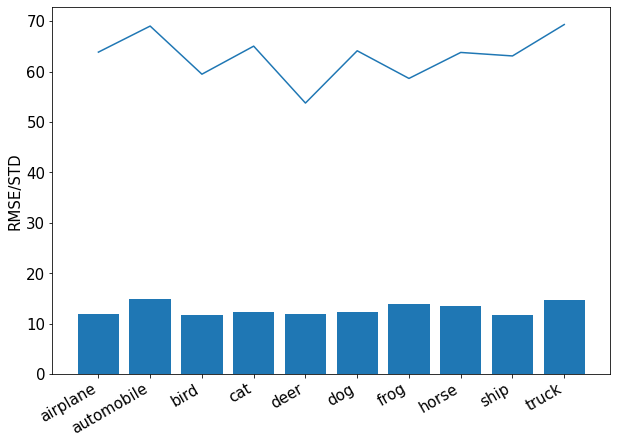

In [45]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)

ax.bar(range(10),rmse_test)
ax.plot(range(10),var_test)
ax.set_xticks(range(10))
ax.set_xticklabels(labels_name.values())

ax.set_ylabel(ylabel='RMSE/STD', fontsize=15)

ax.tick_params(labelsize=15)

fig.autofmt_xdate()

plt.savefig('images/cifar10_ae/cifar10_ae_rmse.png',dpi=120)
plt.show()

## t-SNE visualization

In [23]:
from sklearn.manifold import TSNE

latent_manifold = TSNE(n_components=2, random_state=33)
latent_points = latent_manifold.fit_transform(encoded_imgs)


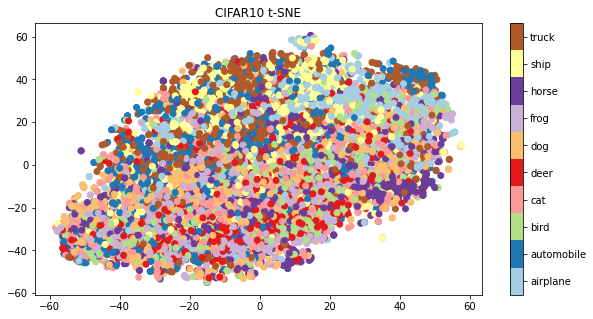

In [35]:
plt.figure(figsize=(10, 5))
plt.scatter(latent_points[:, 0], 
    latent_points[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/cifar10_ae/cifar10_tsne.png', dpi=120)
plt.title('CIFAR10 t-SNE')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(labels_name)
plt.show()

## UMAP visualization

In [89]:
import umap.umap_ as umap
import umap.plot

In [26]:
umap

<module 'umap' from 'D:\\Python\\lib\\site-packages\\umap\\__init__.py'>

In [90]:
mapper = umap.UMAP().fit(encoded_imgs)

<AxesSubplot:>

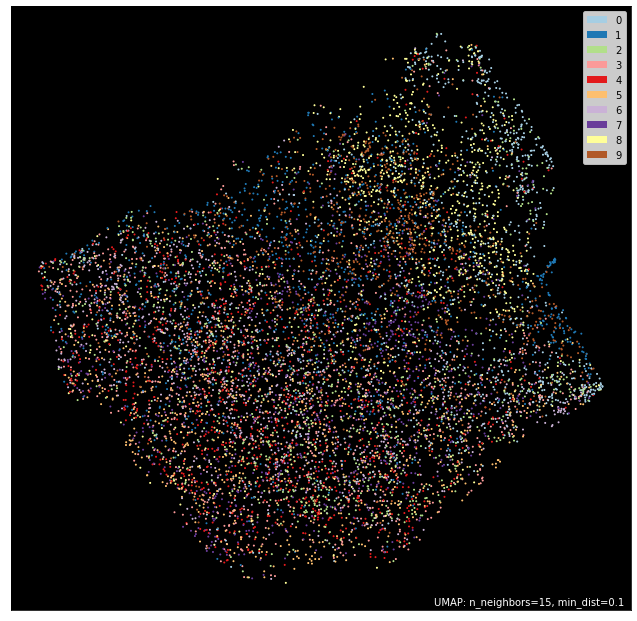

In [27]:
umap.plot.points(mapper, labels=labels_test.reshape(-1,), color_key_cmap='Paired', background='black')

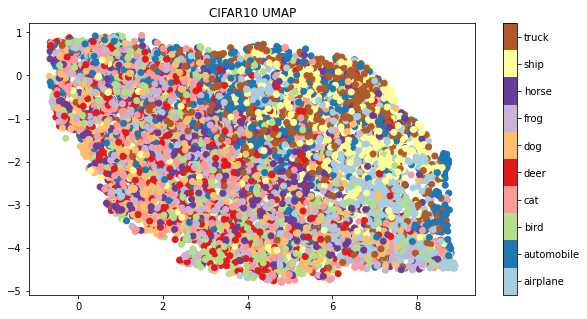

In [91]:
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="UMAP")
plt.savefig('images/cifar10_ae/cifar10_umap.png', dpi=120)
plt.title('CIFAR10 UMAP')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(labels_name)
plt.show()

### KMean Clustering


In [92]:
import sklearn.cluster as cluster

In [93]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(encoded_imgs)

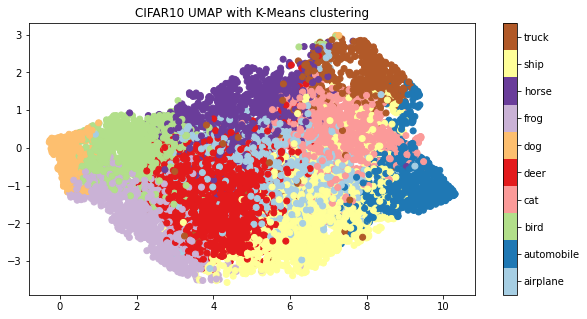

In [58]:
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=kmeans_labels, 
    cmap='Paired',
    label="UMAP")
plt.savefig('images/cifar10_ae/cifar10_umap_cluster.png', dpi=120)
plt.title('CIFAR10 UMAP with K-Means clustering')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(labels_name)
plt.show()

## export architecture

In [35]:
%load_ext tensorboard

In [36]:
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.